In [8]:
import numpy as np
import healpy as hp
import json
from astropy.table import Table, vstack, join
from astropy.io import fits
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/global/homes/h/hrincon/python_tools')
import VoidVolume as vol
import VoidOverlap as vo
import VoidCatalog as vc
import VoidSlicePlots as vsp

from vast.voidfinder.postprocessing import mknum
from vast.voidfinder.postprocessing import open_fits_file


<frozen importlib._bootstrap>:241: RuntimeWarning: vast.voidfinder._voidfinder_cython_find_next.SpatialMap size changed, may indicate binary incompatibility. Expected 1848 from C header, got 2272 from PyObject


# Read in Void Catalogs

In [10]:
#DESI
#------
iron_smoothed_ngc_path = f'../galaxy_catalog/iron_smoothed_ngc.fits'
iron_smoothed_sgc_path = f'../galaxy_catalog/iron_smoothed_sgc.fits'

#VoidFinder
voids_ngc_path = f'../voids/data/minus20.0/DESIVAST_NGC_VoidFinder_Output.fits'
voids_sgc_path = f'../voids/data/minus20.0/DESIVAST_SGC_VoidFinder_Output.fits'

vfc = vc.VoidFinderCatalogStacked(['NGC','SGC'],[voids_ngc_path,voids_sgc_path])
vfc.add_galaxies([iron_smoothed_ngc_path,iron_smoothed_sgc_path])  

#VIDE
voids_ngc_path = f'../voids/data/minus20.0/DESIVAST_NGC_V2_VIDE_Output.fits'
voids_sgc_path = f'../voids/data/minus20.0/DESIVAST_SGC_V2_VIDE_Output.fits'

v2v = vc.V2CatalogStacked(['NGC','SGC'],[voids_ngc_path,voids_sgc_path])
v2v.add_galaxies([iron_smoothed_ngc_path,iron_smoothed_sgc_path]) 

#REVOLVER
voids_ngc_path = f'../voids/data/minus20.0/DESIVAST_NGC_V2_REVOLVER_Output.fits'
voids_sgc_path = f'../voids/data/minus20.0/DESIVAST_SGC_V2_REVOLVER_Output.fits'

v2r = vc.V2CatalogStacked(['NGC','SGC'],[voids_ngc_path,voids_sgc_path])
v2r.add_galaxies([iron_smoothed_ngc_path,iron_smoothed_sgc_path]) 

#SDSS
#------
nsa_path= f'../galaxy_catalog/SDSS_galaxies/nsa_k1.fits'

#VoidFinder
voids_ngc_path = f'../voids/data/minus20.0/SDSSK1_VoidFinder_Output.fits'

vfc_sdss = vc.VoidFinderCatalog(voids_ngc_path)
vfc_sdss.add_galaxies(nsa_path)  

#VIDE
voids_ngc_path = f'../voids/data/minus20.0/SDSSK1_V2_VIDE_Output.fits'

v2v_sdss = vc.V2Catalog(voids_ngc_path)
v2v_sdss.add_galaxies(nsa_path)  

#REVOLVER
voids_ngc_path = f'../voids/data/minus20.0/SDSSK1_V2_REVOLVER_Output.fits'

v2r_sdss = vc.V2Catalog(voids_ngc_path)
v2r_sdss.add_galaxies(nsa_path)  

In [29]:
#ZOBOV
voids_ngc_path = f'../voids/data/volume_filling/DESIVAST_NGC_V2_ZOBOV_Output.fits'
voids_sgc_path = f'../voids/data/volume_filling/DESIVAST_SGC_V2_ZOBOV_Output.fits'

v2z = vc.V2CatalogStacked(['NGC','SGC'],[voids_ngc_path,voids_sgc_path])
v2z.add_galaxies([iron_smoothed_ngc_path,iron_smoothed_sgc_path]) 


In [3]:
# Copy angular mask from VoidFinder catalogs to V2 catalogs

v2r['NGC'].mask = vfc['NGC'].mask
v2r['NGC'].mask_info = vfc['NGC'].mask_info
v2v['NGC'].mask = vfc['NGC'].mask
v2v['NGC'].mask_info = vfc['NGC'].mask_info

v2r['SGC'].mask = vfc['SGC'].mask
v2r['SGC'].mask_info = vfc['SGC'].mask_info
v2v['SGC'].mask = vfc['SGC'].mask
v2v['SGC'].mask_info = vfc['SGC'].mask_info

v2r_sdss.mask = vfc_sdss.mask
v2r_sdss.mask_info = vfc_sdss.mask_info
v2v_sdss.mask = vfc_sdss.mask
v2v_sdss.mask_info = vfc_sdss.mask_info

In [30]:
v2z['NGC'].mask = vfc['NGC'].mask
v2z['NGC'].mask_info = vfc['NGC'].mask_info

v2z['SGC'].mask = vfc['SGC'].mask
v2z['SGC'].mask_info = vfc['SGC'].mask_info

Number of voids in the void hierarchy vs number of top-level parent voids

In [48]:
# REVOLVER
len(np.unique(v2r['NGC'].zonevoid['void0']))-1 + len(np.unique(v2r['SGC'].zonevoid['void0']))-1, \
len(np.unique(v2r['NGC'].zonevoid['void1']))-1 + len(np.unique(v2r['SGC'].zonevoid['void1']))-1

(1992, 1992)

In [49]:
# VIDE
len(np.unique(v2v['NGC'].zonevoid['void0']))-1 + len(np.unique(v2v['SGC'].zonevoid['void0']))-1, \
len(np.unique(v2v['NGC'].zonevoid['void1']))-1 + len(np.unique(v2v['SGC'].zonevoid['void1']))-1

(1478, 1257)

In [50]:
# ZOBOV
len(np.unique(v2z['NGC'].zonevoid['void0'])) + len(np.unique(v2z['SGC'].zonevoid['void0'])), \
len(np.unique(v2z['NGC'].zonevoid['void1'])) + len(np.unique(v2z['SGC'].zonevoid['void1']))-1 # no  -1 because all zones are in voids

(3519, 1)

In [65]:
# Number of VIDE top level parent voids that are interior voids
v2v_parents_ngc = v2v['NGC'].voids[np.isin(v2v['NGC'].voids['void'], np.unique(v2v['NGC'].zonevoid['void1'])[1:])]
v2v_parents_sgc = v2v['SGC'].voids[np.isin(v2v['SGC'].voids['void'], np.unique(v2v['SGC'].zonevoid['void1'])[1:])] #[1:] removes the -1 entry
len(v2v_parents_ngc[v2v_parents_ngc['edge_area']/v2v_parents_ngc['tot_area'] <= .1]) + \
len(v2v_parents_sgc[v2v_parents_sgc['edge_area']/v2v_parents_sgc['tot_area'] <= .1])

249

Median radii for low redshift voids withing SDSS limit (z<.114)

In [4]:
np.median(
    np.array(
        vstack(
            [vfc['NGC'].maximals[vfc['NGC'].maximals['r']<332], 
             vfc['SGC'].maximals[vfc['SGC'].maximals['r']<332]]
        )['r_eff']
    ).astype(float)
)

14.712931036341367

In [5]:
np.median(
    np.array(
        vstack(
            [v2v['NGC'].voids[v2v['NGC'].voids['redshift']<.114], 
             v2v['SGC'].voids[v2v['SGC'].voids['redshift']<.114]]
        )['radius']
    ).astype(float)
)

14.250741158582294

In [6]:
np.median(
    np.array(
        vstack(
            [v2r['NGC'].voids[v2r['NGC'].voids['redshift']<.114], 
             v2r['SGC'].voids[v2r['SGC'].voids['redshift']<.114]]
        )['radius']
    ).astype(float)
)

14.583304143194567

In [17]:
# Unused code
masks_path = f'../galaxy_catalog/mask/alt_masks/masks.fits'

masks = fits.open(masks_path)

# Catalog General Properties

In [5]:
redtext = lambda x: f"\x1b[31m{x}\x1b[0m"

In [6]:
print('\n'+redtext("DESI VoidFinder"),'\n')
vfc.void_stats()
print('\n'+redtext("DESI VIDE"),'\n')
v2v.void_stats()
print('\n'+redtext("DESI REVOVLER"),'\n')
v2r.void_stats()
print('\n'+redtext("SDSS VoidFinder"),'\n')
vfc_sdss.void_stats()
print('\n'+redtext("SDSS VIDE"),'\n')
v2v_sdss.void_stats()
print('\n'+redtext("SDSS REVOLVER"),'\n')
v2r_sdss.void_stats()


DESI VoidFinder 

NGC
3241 voids
1872 edge voids
36 near-edge voids
1333 interior voids
69 edge voids (V. Fid)
1 near-edge voids (V. Fid)
859 interior voids (V. Fid)
Mean Reff (V. Fid): 16.51 +/- 0.0553 Mpc/h
Median Reff (V. Fid): 15.7 +/- 0.0693 Mpc/h
Maximum Reff (V. Fid): 31.69 Mpc/h

SGC
524 voids
360 edge voids
8 near-edge voids
156 interior voids
10 edge voids (V. Fid)
0 near-edge voids (V. Fid)
83 interior voids (V. Fid)
Mean Reff (V. Fid): 16.36 +/- 0.137 Mpc/h
Median Reff (V. Fid): 15.27 +/- 0.172 Mpc/h
Maximum Reff (V. Fid): 26.03 Mpc/h

Combined
3765 voids
2232 edge voids
44 near-edge voids
1489 interior voids
Mean Reff (V. Fid): 16.5 +/- 0.0513 Mpc/h
Median Reff (V. Fid): 15.68 +/- 0.0643 Mpc/h
Maximum Reff (V. Fid): 31.69 Mpc/h

DESI VIDE 

NGC
1258 voids
989 edge voids
269 interior voids
176 edge voids (V. Fid)
225 interior voids (V. Fid)
Mean Reff (V. Fid): 21.47 +/- 0.244 Mpc/h
Median Reff (V. Fid): 19.55 +/- 0.306 Mpc/h
Maximum Reff (V. Fid): 55.88 Mpc/h

SGC
220 void

# Volume Overlap

In [2]:
def sum_quad(lis):
    arr = np.array(lis)**2
    arr = np.sum(arr)
    arr = np.sqrt(arr)
    return arr

idx='000'
idx_list = [idx]
for i in range(24):
    idx = idx[0]+idx[1]+str(int(idx[2]) + 1)
    if int(idx[2]) == 4:
        idx = idx[0] +  str(int(idx[1]) + 1) + '0'

        if int(idx[1]) == 4:
            idx = str(int(idx[0]) + 1) + '00'
    idx_list.append(idx)

In [3]:
with open(f'./analysis/void_frac.json') as f:
    void_frac = json.load(f)
void_frac_mock = {}
with open(f'../mocks/altmtl/analysis/void_frac.json') as f:
    void_frac_mock_desi = json.load(f)
    for i in range(25):
        void_frac_mock_desi[f'VF/VV ({i})'] = void_frac_mock_desi[f'VF/VV ({i})']['Shared']
        void_frac_mock_desi[f'VF/VR ({i})'] = void_frac_mock_desi[f'VF/VR ({i})']['Shared']
        void_frac_mock_desi[f'VV/VR ({i})'] = void_frac_mock_desi[f'VV/VR ({i})']['Shared'] 
    void_frac_mock['DESI'] = void_frac_mock_desi   
with open(f'../mocks/HorizonRun4/analysis/void_frac.json') as f:
    void_frac_mock_sdss = json.load(f)
    for i in idx_list:
        void_frac_mock_sdss[f'VF/VV ({i})'] = void_frac_mock_sdss[f'VF/VV ({i})']['Shared']
        void_frac_mock_sdss[f'VF/VR ({i})'] = void_frac_mock_sdss[f'VF/VR ({i})']['Shared']
        void_frac_mock_sdss[f'VV/VR ({i})'] = void_frac_mock_sdss[f'VV/VR ({i})']['Shared'] 
    void_frac_mock['SDSS'] = void_frac_mock_sdss


In [4]:
def get_void_frac(survey, algorithm, magnitude):
    if survey == 'DESI':
        void_key = 'Void'
        if '/' in algorithm:
            void_key = 'Shared'
        ngc_vol = void_frac[f'NGC : {algorithm} ({magnitude}) '][void_key] * void_frac[f'NGC : {algorithm} ({magnitude}) ']['Num. points'] 
        sgc_vol = void_frac[f'SGC : {algorithm} ({magnitude}) '][void_key] * void_frac[f'SGC : {algorithm} ({magnitude}) ']['Num. points']
        total_vol = void_frac[f'NGC : {algorithm} ({magnitude}) ']['Num. points'] + void_frac[f'SGC : {algorithm} ({magnitude}) ']['Num. points']
        frac = (ngc_vol + sgc_vol) / total_vol
        return frac / 100
    if survey == 'SDSS':
        void_key = 'Void'
        if '/' in algorithm:
            void_key = 'Shared'
        frac = void_frac[f'SDSS : {algorithm} ({magnitude}) '][void_key] 
        return frac / 100
    
def report_void_frac(algorithm):
    frac = get_void_frac('DESI', algorithm, -20.0)
    print(frac)
    mock_trials = [void_frac_mock['DESI'][f'{algorithm} ({x})'] for x in range(25)]
    stat_uncert = np.std(mock_trials)
    print('note: average mock value is', mknum(np.mean(mock_trials)))
    sys_uncert_low = get_void_frac('DESI', algorithm, -19.89) - frac 
    sys_uncert_high = get_void_frac('DESI', algorithm, -20.06) - frac 
    if sys_uncert_low/abs(sys_uncert_low) == sys_uncert_high/abs(sys_uncert_high):
        print("Magnitude trend is not monotonic")
        
    def format_sign(number):
        string = str(mknum(number))
        if string[0] != '-':
            string = '+' + string
        return string
    
    frac, sys_uncert_low, sys_uncert_high = 100 * frac, 100 * sys_uncert_low, 100 * sys_uncert_high
    if '/' in algorithm:
        stat_uncert *= 100
    
    print(f'{algorithm} : ({mknum(frac)} {format_sign(sys_uncert_high)} {format_sign(sys_uncert_low)} +/- {mknum(stat_uncert)}) %')

In [5]:
def report_void_frac_sdss(algorithm):
    frac = get_void_frac('SDSS', algorithm, -20.0)
    mock_trials = [void_frac_mock['SDSS'][f'{algorithm} ({x})'] for x in idx_list]
    stat_uncert = np.std(mock_trials)
    print('note: average mock value is', mknum(np.mean(mock_trials)))
    sys_uncert_low =get_void_frac('SDSS', algorithm, -19.94)-frac
    sys_uncert_high = get_void_frac('SDSS', algorithm, -20.11)-frac
    if sys_uncert_low/abs(sys_uncert_low) == sys_uncert_high/abs(sys_uncert_high):
        print("Magnitude trend is not monotonic")
    def format_sign(number):
        string = str(mknum(number))
        if string[0] != '-':
            string = '+' + string
        return string
    
    frac, sys_uncert_low, sys_uncert_high = 100 * frac, 100 * sys_uncert_low, 100 * sys_uncert_high
    if '/' in algorithm:
        stat_uncert *= 100
    
    print(f'{algorithm} : ({mknum(frac)} {format_sign(sys_uncert_high)} {format_sign(sys_uncert_low)} +/- {mknum(stat_uncert)}) %')

In [6]:
report_void_frac('VF')
report_void_frac('VV')
report_void_frac('VR')
report_void_frac('VF/VV')
report_void_frac('VF/VR')
report_void_frac('VV/VR')

0.6279103533833135
note: average mock value is 49.68
VF : (62.79 +1.3 -2.1 +/- 1.18) %
0.6934379355134566
note: average mock value is 66.31
Magnitude trend is not monotonic
VV : (69.34 +0.508 +3.03 +/- 3.04) %
0.9867436719807684
note: average mock value is 97.14
Magnitude trend is not monotonic
VR : (98.67 -0.0342 -0.245 +/- 0.242) %
0.4361317355448556
note: average mock value is 0.326
Magnitude trend is not monotonic
VF/VV : (43.61 +1.22 +0.483 +/- 2.02) %
0.6215223449481908
note: average mock value is 0.482
VF/VR : (62.15 +1.27 -2.1 +/- 1.23) %
0.6931871514150791
note: average mock value is 0.663
Magnitude trend is not monotonic
VV/VR : (69.32 +0.531 +3.03 +/- 3.04) %


In [17]:
report_void_frac_sdss('VF')
report_void_frac_sdss('VV')
report_void_frac_sdss('VR')
report_void_frac_sdss('VF/VV')
report_void_frac_sdss('VF/VR')
report_void_frac_sdss('VV/VR')

note: average mock value is 60.24
VF : (62.68 +2.06 -0.967 +/- 0.807) %
note: average mock value is 68.49
Magnitude trend is not monotonic
VV : (69.92 +3.77 +0.401 +/- 3.21) %
note: average mock value is 92.21
Magnitude trend is not monotonic
VR : (99.0 +0.3 +0.0627 +/- 0.448) %
note: average mock value is 0.411
VF/VV : (44.01 +3.78 -0.672 +/- 1.93) %
note: average mock value is 0.569
VF/VR : (62.49 +2.03 -1.01 +/- 0.848) %
note: average mock value is 0.642
Magnitude trend is not monotonic
VV/VR : (69.92 +3.75 +0.401 +/- 3.16) %


# Galaxy Membership

In [8]:
with open(f'./analysis/gal_frac.json') as f:
    gal_frac = json.load(f)
gal_frac_mock = {}
with open(f'../mocks/altmtl/analysis/gal_frac.json') as f:
    gal_frac_mock_desi = json.load(f)
    gal_frac_mock['DESI'] = gal_frac_mock_desi
with open(f'../mocks/HorizonRun4/analysis/gal_frac.json') as f:
    gal_frac_mock_sdss = json.load(f)
    gal_frac_mock['SDSS'] = gal_frac_mock_sdss

In [9]:
def get_gal_frac(survey, algorithm, magnitude):
    if survey == 'DESI':
        frac = gal_frac[f'NGC : {algorithm} ({magnitude}) ']['Num. void'] + gal_frac[f'SGC : {algorithm} ({magnitude}) ']['Num. void']
        frac /= gal_frac[f'NGC : {algorithm} ({magnitude}) ']['Num. total'] + gal_frac[f'SGC : {algorithm} ({magnitude}) ']['Num. total']
        return 100 * frac
    if survey == 'SDSS':
        frac = gal_frac[f'SDSS : {algorithm} ({magnitude}) ']['Num. void'] / gal_frac[f'SDSS : {algorithm} ({magnitude}) ']['Num. total']
        return 100 * frac
    

def report_gal_frac(algorithm):
    frac = get_gal_frac('DESI', algorithm, -20.0)
    mock_trials = [gal_frac_mock['DESI'][f'{algorithm} ({x})'] for x in range(25)]
    stat_uncert = np.std(mock_trials)
    print('note: average mock value is', mknum(np.mean(mock_trials)))
    sys_uncert_low = get_gal_frac('DESI', algorithm, -19.89) - frac
    sys_uncert_high = get_gal_frac('DESI', algorithm, -20.06) - frac
    if sys_uncert_low/abs(sys_uncert_low) == sys_uncert_high/abs(sys_uncert_high):
        print("Magnitude trend is not monotonic")
    def format_sign(number):
        string = str(mknum(number))
        if string[0] != '-':
            string = '+' + string
        return string
    
    print(f'{algorithm} : ({mknum(frac)} {format_sign(sys_uncert_high)} {format_sign(sys_uncert_low)} +/- {mknum(stat_uncert)}) %')

In [10]:
def report_gal_frac_sdss(algorithm):
    frac =  get_gal_frac('SDSS', algorithm, -20.0)
    mock_trials = [gal_frac_mock['SDSS'][f'{algorithm} ({x})'] for x in idx_list]
    stat_uncert = np.std(mock_trials)
    print('note: average mock value is', mknum(np.mean(mock_trials)))
    sys_uncert_low =  get_gal_frac('SDSS', algorithm, -19.94) - frac
    sys_uncert_high =  get_gal_frac('SDSS', algorithm, -20.11) - frac
    if sys_uncert_low/abs(sys_uncert_low) == sys_uncert_high/abs(sys_uncert_high):
        print("Magnitude trend is not monotonic")
    def format_sign(number):
        string = str(mknum(number))
        if string[0] != '-':
            string = '+' + string
        return string
    
    print(f'{algorithm} : ({mknum(frac)} {format_sign(sys_uncert_high)} {format_sign(sys_uncert_low)} +/- {mknum(stat_uncert)}) %')

In [11]:
report_gal_frac('VF')
report_gal_frac('VV')
report_gal_frac('VR')
report_gal_frac('VF/VV')
report_gal_frac('VF/VR')
report_gal_frac('VV/VR')

note: average mock value is 17.73
VF : (22.82 +1.15 -2.02 +/- 0.796) %
note: average mock value is 67.5
Magnitude trend is not monotonic
VV : (69.74 +0.359 +2.7 +/- 2.6) %
note: average mock value is 97.85
Magnitude trend is not monotonic
VR : (98.61 -0.0677 -0.52 +/- 0.254) %
note: average mock value is 11.87
VF/VV : (16.07 +1.04 -0.866 +/- 0.795) %
note: average mock value is 17.33
VF/VR : (22.64 +1.14 -2.01 +/- 0.794) %
note: average mock value is 67.5
Magnitude trend is not monotonic
VV/VR : (69.72 +0.368 +2.69 +/- 2.6) %


In [21]:
report_gal_frac('VF')
report_gal_frac('VV')
report_gal_frac('VR')
report_gal_frac('VF/VV')
report_gal_frac('VF/VR')
report_gal_frac('VV/VR')

note: average mock value is 17.73
VF : (22.78 +1.23 -2.05 +/- 0.796) %
note: average mock value is 67.5
Magnitude trend is not monotonic
VV : (69.65 +0.729 +0.467 +/- 2.6) %
note: average mock value is 97.85
Magnitude trend is not monotonic
VR : (98.54 -0.0187 -0.583 +/- 0.254) %
note: average mock value is 11.87
VF/VV : (16.01 +1.19 -1.32 +/- 0.795) %
note: average mock value is 17.33
VF/VR : (22.58 +1.23 -2.03 +/- 0.794) %
note: average mock value is 67.5
Magnitude trend is not monotonic
VV/VR : (69.64 +0.737 +0.46 +/- 2.6) %


In [22]:
report_gal_frac_sdss('VF')
report_gal_frac_sdss('VV')
report_gal_frac_sdss('VR')
report_gal_frac_sdss('VF/VV')
report_gal_frac_sdss('VF/VR')
report_gal_frac_sdss('VV/VR')


note: average mock value is 19.71
VF : (20.34 +1.93 -0.933 +/- 0.515) %
note: average mock value is 69.26
Magnitude trend is not monotonic
VV : (69.63 +3.39 +1.09 +/- 3.22) %
note: average mock value is 90.12
Magnitude trend is not monotonic
VR : (98.31 +0.527 +0.124 +/- 0.629) %
note: average mock value is 13.74
VF/VV : (14.34 +2.1 -0.601 +/- 0.651) %
note: average mock value is 18.7
VF/VR : (20.3 +1.91 -0.955 +/- 0.498) %
note: average mock value is 63.32
Magnitude trend is not monotonic
VV/VR : (69.63 +3.38 +1.09 +/- 3.1) %


# Slice Plots

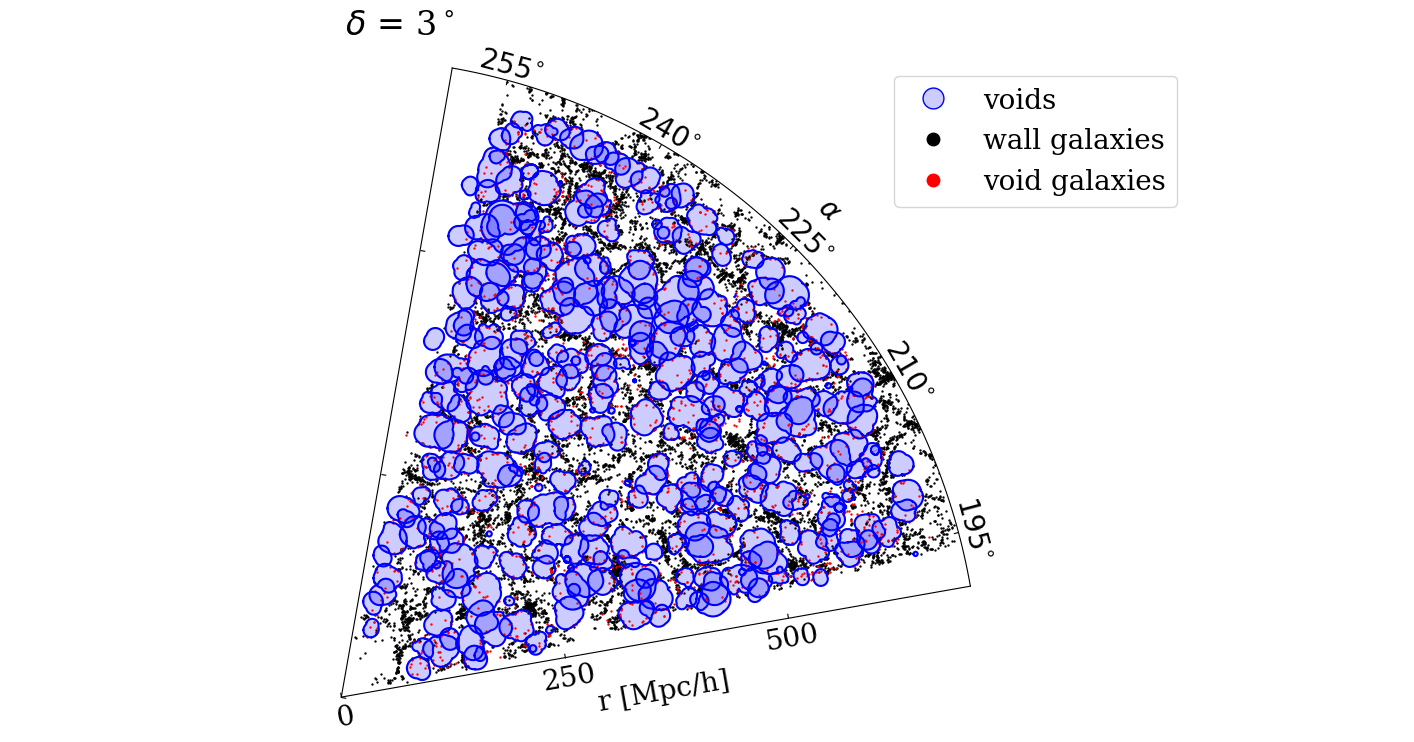

In [20]:

vm = vsp.VoidMapVF(vfc['NGC'].galaxies,vfc['NGC'].maximals,vfc['NGC'].holes)

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

graph = vm.pvf2(3,5,1000,6, 
    190, 260, 0, 0.25, "", graph = None, zlimits = True, rot = 180, 
    colors = ['blue','blue','blue'],include_gals=True,alpha=0.2, border_alpha = 1,
    horiz_legend_offset=0.85,mag_limit=-20, galaxy_point_size=.5,
    plot_sdss=False)
plt.savefig("sliceplot_vf_blue.png", bbox_inches = "tight")

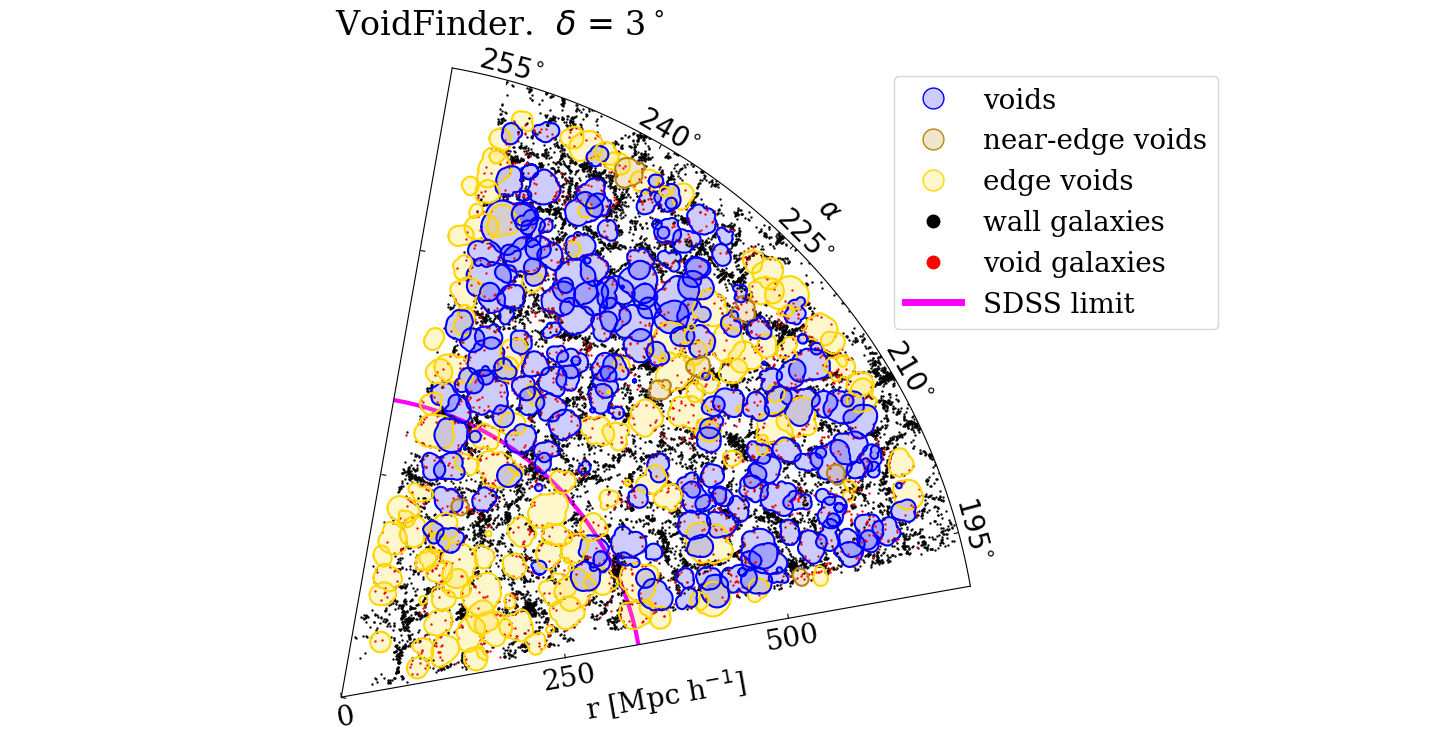

In [12]:
vm = vsp.VoidMapVF(vfc['NGC'].galaxies,vfc['NGC'].maximals,vfc['NGC'].holes)

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

graph, data_points = vm.pvf2(3,5,1000,6, 
    190, 260, 0, 0.25, "VoidFinder. ", graph = None, zlimits = True, rot = 180, 
    colors = ['gold','darkgoldenrod','blue'],include_gals=True,alpha=0.2, border_alpha = 1,
    horiz_legend_offset=0.85,mag_limit=-20, galaxy_point_size=.5, return_plot_data = True)
plt.savefig("sliceplot_vf.png", bbox_inches = "tight", dpi=400)

In [22]:
#import importlib
#importlib.reload(vsp)

<module 'VoidSlicePlots' from '/global/homes/h/hrincon/python_tools/VoidSlicePlots.py'>

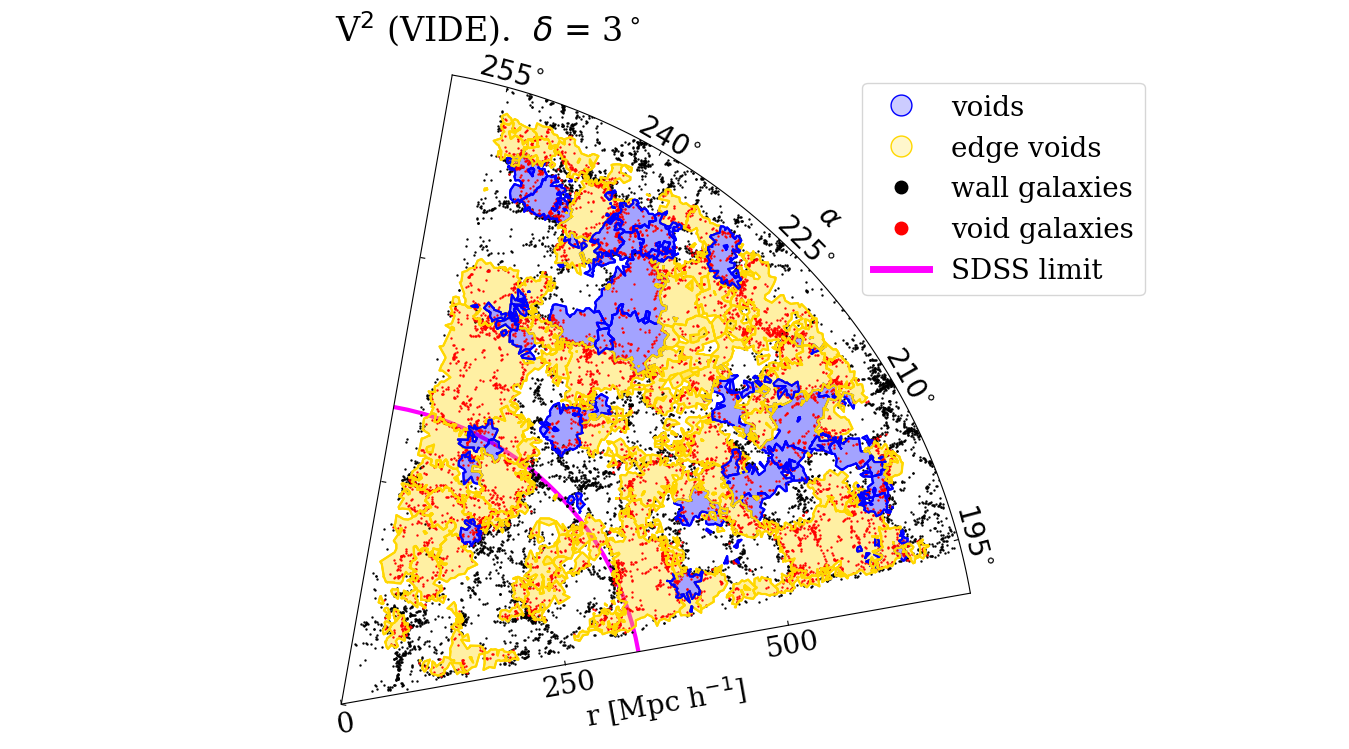

In [9]:
vm = vsp.VoidMapV2(v2v['NGC'].triangle, v2v['NGC'].galzone, v2v['NGC'].zonevoid,
                   v2v['NGC'].voids[v2v['NGC'].voids['underdense']==1], v2v['NGC'].galaxies)

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })
graph, data_points_REV = vm.pzbv(3,5,
    190, 260, 0, 0.25, "V$^2$ (VIDE). ", graph = None, zlimits = True, rot = 180, 
    colors = ['gold','blue'],include_gals=True,alpha=0.2, border_alpha = 1, mag_limit=-20, galaxy_point_size=.5, return_plot_data = True)
plt.savefig("sliceplot_vv.png", bbox_inches = "tight", dpi=400)

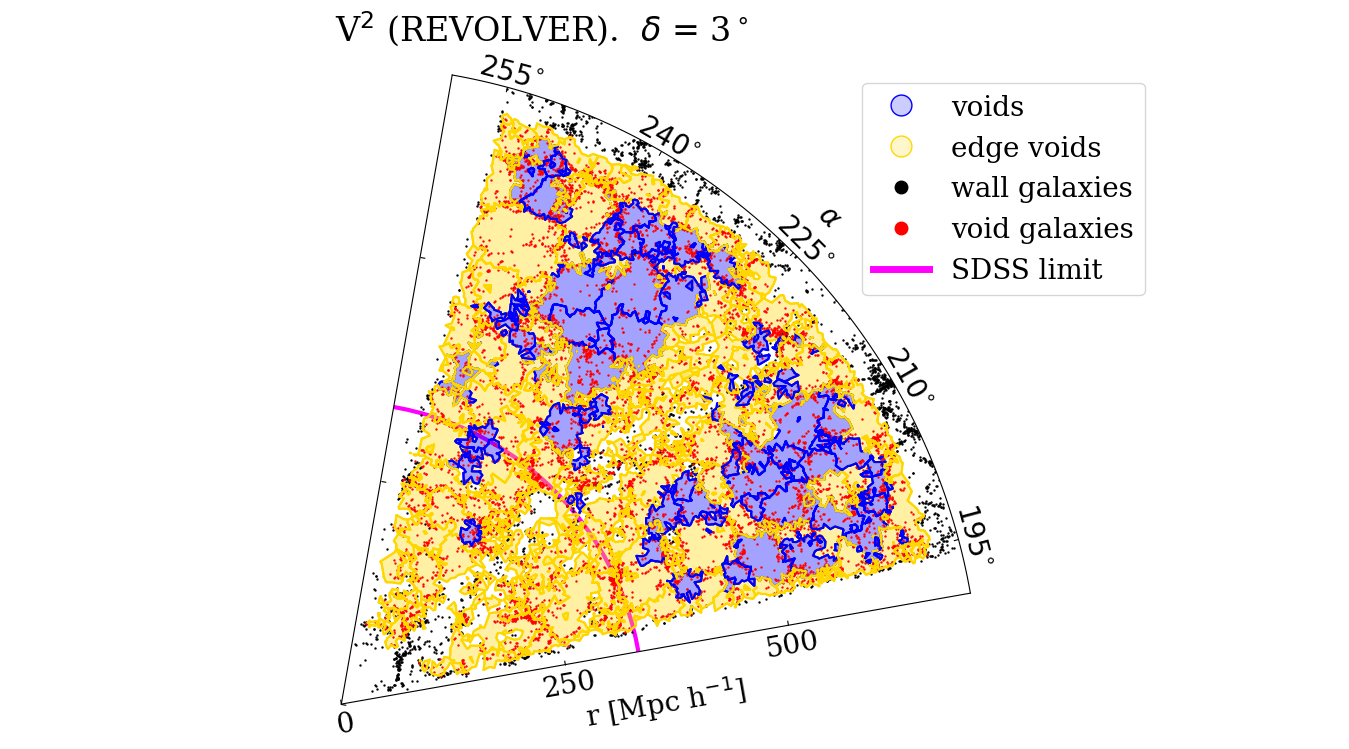

In [10]:
vm = vsp.VoidMapV2(v2r['NGC'].triangle, v2r['NGC'].galzone, v2r['NGC'].zonevoid,
                   v2r['NGC'].voids, v2r['NGC'].galaxies)

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })
graph, data_points_VIDE = vm.pzbv(3,5,
    190, 260, 0, 0.25, "V$^2$ (REVOLVER). ", graph = None, zlimits = True, rot = 180, 
    colors = ['gold','blue'],include_gals=True,alpha=0.2, border_alpha = 1, mag_limit=-20, galaxy_point_size=.5, return_plot_data = True)
plt.savefig("sliceplot_vr.png", bbox_inches = "tight", dpi=400)

In [16]:
#output figures to DMP directory
import shutil

shutil.copyfile("sliceplot_vf.png", "/global/cfs/cdirs/desi/users/hrincon/DESIVAST/DMP/sliceplot_vf.png");
shutil.copyfile("sliceplot_vv.png", "/global/cfs/cdirs/desi/users/hrincon/DESIVAST/DMP/sliceplot_vv.png");
shutil.copyfile("sliceplot_vr.png", "/global/cfs/cdirs/desi/users/hrincon/DESIVAST/DMP/sliceplot_vr.png");

Save figure info for Data Management Plan

In [13]:
dmp_ra=[]
dmp_r=[]
dmp_void = []
for i, void in enumerate(data_points[:-2]):
    dmp_ra.extend(void[0])
    dmp_r.extend(void[1])
    dmp_void.extend(i * np.ones_like(void[1]).astype(int))
    
dmp_gal_w_ra = data_points[-2][0]
dmp_gal_w_r = data_points[-2][1]
dmp_gal_v_ra = data_points[-1][0]
dmp_gal_v_r = data_points[-1][1]

dmp_void_info = Table([dmp_ra, dmp_r, dmp_void], names=['RA','R','GROUP'])
dmp_gal_w_info = Table([dmp_gal_w_ra, dmp_gal_w_r], names=['RA','R'])
dmp_gal_v_info = Table([dmp_gal_v_ra, dmp_gal_v_r], names=['RA','R'])

#save DMP output

dmp_path = '/global/cfs/cdirs/desi/users/hrincon/DESIVAST/DMP/DESIVAST_figures.fits'
dmp_file = open_fits_file(dmp_path)
hdu = fits.BinTableHDU(dmp_void_info)
hdu.name = 'FIG4VF_V'
dmp_file.append(hdu)
hdu = fits.BinTableHDU(dmp_gal_w_info)
hdu.name = 'FIG4VF_W'
dmp_file.append(hdu)
hdu = fits.BinTableHDU(dmp_gal_v_info)
hdu.name = 'FIG4VF_F'
dmp_file.append(hdu)
dmp_file.writeto(dmp_path, overwrite=True)

In [14]:
dmp_ra=[]
dmp_r=[]
dmp_void = []
for i, void in enumerate(data_points_REV[:-2]):
    dmp_ra.extend(void[0])
    dmp_r.extend(void[1])
    dmp_void.extend(i * np.ones_like(void[1]).astype(int))
    
dmp_gal_w_ra = data_points_REV[-2][0]
dmp_gal_w_r = data_points_REV[-2][1]
dmp_gal_v_ra = data_points_REV[-1][0]
dmp_gal_v_r = data_points_REV[-1][1]

dmp_void_info = Table([dmp_ra, dmp_r, dmp_void], names=['RA','R','GROUP'])
dmp_gal_w_info = Table([dmp_gal_w_ra, dmp_gal_w_r], names=['RA','R'])
dmp_gal_v_info = Table([dmp_gal_v_ra, dmp_gal_v_r], names=['RA','R'])

#save DMP output

dmp_path = '/global/cfs/cdirs/desi/users/hrincon/DESIVAST/DMP/DESIVAST_figures.fits'
dmp_file = open_fits_file(dmp_path)
hdu = fits.BinTableHDU(dmp_void_info)
hdu.name = 'FIG4VR_V'
dmp_file.append(hdu)
hdu = fits.BinTableHDU(dmp_gal_w_info)
hdu.name = 'FIG4VR_W'
dmp_file.append(hdu)
hdu = fits.BinTableHDU(dmp_gal_v_info)
hdu.name = 'FIG4VR_F'
dmp_file.append(hdu)
dmp_file.writeto(dmp_path, overwrite=True)

In [15]:
dmp_ra=[]
dmp_r=[]
dmp_void = []
for i, void in enumerate(data_points_VIDE[:-2]):
    dmp_ra.extend(void[0])
    dmp_r.extend(void[1])
    dmp_void.extend(i * np.ones_like(void[1]).astype(int))
    
dmp_gal_w_ra = data_points_VIDE[-2][0]
dmp_gal_w_r = data_points_VIDE[-2][1]
dmp_gal_v_ra = data_points_VIDE[-1][0]
dmp_gal_v_r = data_points_VIDE[-1][1]

dmp_void_info = Table([dmp_ra, dmp_r, dmp_void], names=['RA','R','GROUP'])
dmp_gal_w_info = Table([dmp_gal_w_ra, dmp_gal_w_r], names=['RA','R'])
dmp_gal_v_info = Table([dmp_gal_v_ra, dmp_gal_v_r], names=['RA','R'])

#save DMP output

dmp_path = '/global/cfs/cdirs/desi/users/hrincon/DESIVAST/DMP/DESIVAST_figures.fits'
dmp_file = open_fits_file(dmp_path)
hdu = fits.BinTableHDU(dmp_void_info)
hdu.name = 'FIG4VV_V'
dmp_file.append(hdu)
hdu = fits.BinTableHDU(dmp_gal_w_info)
hdu.name = 'FIG4VV_W'
dmp_file.append(hdu)
hdu = fits.BinTableHDU(dmp_gal_v_info)
hdu.name = 'FIG4VV_F'
dmp_file.append(hdu)
dmp_file.writeto(dmp_path, overwrite=True)

Formating table information for Overleaf tables

In [18]:
print_table = vfc['NGC'].maximals
print(' '.join(print_table.colnames))
for i in range(3):
    row = [str(mknum(x)) if type(x) is np.float64 else str(x) for x in tuple(print_table[i])]
    print(' & '.join(row))

x y z radius void edge r ra dec r_eff r_eff_uncert
-624.51 & -133.79 & -85.41 & 24.04 & 0 & 1 & 644.37 & 192.09 & -7.62 & 30.44 & 0.108
-224.19 & -355.12 & 59.92 & 23.98 & 1 & 1 & 424.22 & 237.74 & 8.12 & 31.69 & 0.114
-140.92 & -585.75 & 152.59 & 23.51 & 2 & 1 & 621.49 & 256.47 & 14.21 & 30.08 & 0.108


In [19]:
print_table = vfc['NGC'].holes
print(' '.join(print_table.colnames))
for i in range(3):
    row = [str(mknum(x)) if type(x) is np.float64 else str(x) for x in tuple(print_table[i])]
    print(' & '.join(row))

x y z radius void
-624.51 & -133.79 & -85.41 & 24.04 & 0
-224.19 & -355.12 & 59.92 & 23.98 & 1
-224.23 & -355.06 & 59.8 & 23.97 & 1


In [20]:
print_table = v2v['NGC'].voids
print(' '.join(print_table.colnames))
for i in range(3):
    row = []
    for x, x_name in zip(print_table[i], print_table.colnames):
        if x_name in ('underdense', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3'):
            continue
        append_value = str(mknum(x)) if type(x) is np.float64 else str(x)
        if x_name == 'x1':
            append_value = append_value +'...'
        row.append(append_value)
    #row = [str(mknum(x)) if type(x) is np.float64 else str(x) for x in tuple(print_table[i])]
    print(' & '.join(row))

void x y z redshift ra dec radius underdense x1 y1 z1 x2 y2 z2 x3 y3 z3 tot_area edge_area
0 & -217.74 & 442.78 & 238.31 & 0.192 & 116.19 & 25.78 & 29.32 & -4.13... & 41568.33 & 14649.29
1 & -36.36 & -269.64 & 85.79 & 0.0974 & 262.32 & 17.5 & 25.1 & -5.35... & 27470.71 & 8740.29
2 & -203.35 & -562.47 & 72.98 & 0.212 & 250.12 & 6.96 & 43.46 & -8.33... & 76671.18 & 4926.86


In [25]:
#number of top level parent voids in VIDE
len(np.unique(v2v['NGC'].zonevoid['void1'])) 

1060

In [26]:
print_table = v2v['NGC'].zonevoid
print(' '.join(print_table.colnames))
for i in range(3):
    row = [str(mknum(x)) if type(x) is np.float64 else str(x) for x in tuple(print_table[i])]
    print(' & '.join(row))

zone void0 void1
0 & 1257 & 1257
1 & -1 & -1
2 & -1 & -1


In [27]:
print_table = v2v['NGC'].galzone
print(' '.join(print_table.colnames))
for i in range(3):
    row = [str(mknum(x)) if type(x) is np.float64 else str(x) for x in tuple(print_table[i])]
    print(' & '.join(row))

gal target x y z zone depth edge out
0 & 39627540897202342 & -549.38 & 210.35 & -105.09 & 2949 & 0 & 1 & 0
1 & 39627540897202561 & -313.07 & 119.55 & -60.12 & 2949 & 0 & 1 & 0
2 & 39627540897202679 & -521.83 & 198.87 & -99.74 & 2949 & 0 & 1 & 0


In [28]:
print_table = v2v['NGC'].galviz
print(' '.join(print_table.colnames))
for i in range(3):
    row = [str(mknum(x)) if type(x) is np.float64 else str(x) for x in tuple(print_table[i])]
    print(' & '.join(row))

gid g2v g2v2
0 & -1 & -1
1 & -1 & -1
2 & -1 & -1


In [29]:
print_table = v2v['NGC'].triangle
print(' '.join(print_table.colnames))
for i in range(3):
    row = []
    for x, x_name in zip(print_table[i], print_table.colnames):
        append_value = str(mknum(x)) if type(x) is np.float64 else str(x)
        if x_name in ('n_x', 'p1_x'):
            append_value = append_value +'...'
        elif x_name[0] in ('n', 'p'):
            continue
        row.append(append_value)
    #row = [str(mknum(x)) if type(x) is np.float64 else str(x) for x in tuple(print_table[i])]
    print(' & '.join(row))

void n_x n_y n_z p1_x p1_y p1_z p2_x p2_y p2_z p3_x p3_y p3_z
1 & 0.838... & -29.11...
1 & -0.497... & -33.54...
1 & -0.497... & -33.54...


In [ ]:
#Output all catalogs
out_dir = '/global/cfs/cdirs/desi/users/hrincon/DESIVAST_V1/'

hdul = fits.open('../voids/data/minus20.0/DESIVAST_NGC_VoidFinder_Output.fits')
hdul.pop(index=-1) #remove extra HDUs
hdul.pop(index=1)
hdul.pop(index=1)
hdul.pop(index=1)

units={'RA':'deg','DEC':'deg',
       'X':'Mpc h-1','Y':'Mpc h-1','Z':'Mpc h-1',
       'RADIUS':'Mpc h-1','R':'Mpc h-1',
       'R_EFF':'Mpc h-1', 'R_EFF_UNCERT':'Mpc h-1'}
for key, value in units.items():
    hdul[1].columns.change_unit(key, value)
    if key in hdul[2].columns.names:
        hdul[2].columns.change_unit(key, value)

hdul.writeto(out_dir+"DESIVAST_BGS_VOLLIM_VoidFinder_NGC.fits")

hdul = fits.open('../voids/data/minus20.0/DESIVAST_SGC_VoidFinder_Output.fits')
hdul.pop(index=-1)
hdul.pop(index=1)
hdul.pop(index=1)
hdul.pop(index=1)

units={'RA':'deg','DEC':'deg',
       'X':'Mpc h-1','Y':'Mpc h-1','Z':'Mpc h-1',
       'RADIUS':'Mpc h-1','R':'Mpc h-1',
       'R_EFF':'Mpc h-1', 'R_EFF_UNCERT':'Mpc h-1'}
for key, value in units.items():
    hdul[1].columns.change_unit(key, value)
    if key in hdul[2].columns.names:
        hdul[2].columns.change_unit(key, value)
        
hdul.writeto(out_dir+"DESIVAST_BGS_VOLLIM_VoidFinder_SGC.fits")

hdul = fits.open('../voids/data/minus20.0/DESIVAST_NGC_V2_REVOLVER_Output.fits')
hdul.pop(index=1)
#tmp_table = Table(hdul['VOIDS'].data) # remove underdense column
#tmp_table.remove_column('UNDERDENSE')
#hdul['VOIDS'].data =  fits.BinTableHDU(tmp_table).data
hdul['VOIDS'].columns.del_col('UNDERDENSE')
units={'X':'Mpc h-1','Y':'Mpc h-1','Z':'Mpc h-1'}
for key, value in units.items():
    hdul[3].columns.change_unit(key, value)
hdul.writeto(out_dir+"DESIVAST_BGS_VOLLIM_V2_REVOLVER_NGC.fits")

hdul = fits.open('../voids/data/minus20.0/DESIVAST_SGC_V2_REVOLVER_Output.fits')
hdul.pop(index=1)
hdul['VOIDS'].columns.del_col('UNDERDENSE')
units={'X':'Mpc h-1','Y':'Mpc h-1','Z':'Mpc h-1'}
for key, value in units.items():
    hdul[3].columns.change_unit(key, value)
hdul.writeto(out_dir+"DESIVAST_BGS_VOLLIM_V2_REVOLVER_SGC.fits")

hdul = fits.open('../voids/data/minus20.0/DESIVAST_NGC_V2_VIDE_Output.fits')
hdul.pop(index=1)
hdul['VOIDS'].columns.del_col('UNDERDENSE')
units={'X':'Mpc h-1','Y':'Mpc h-1','Z':'Mpc h-1'}
for key, value in units.items():
    hdul[3].columns.change_unit(key, value)
hdul.writeto(out_dir+"DESIVAST_BGS_VOLLIM_V2_VIDE_NGC.fits")

hdul = fits.open('../voids/data/minus20.0/DESIVAST_SGC_V2_VIDE_Output.fits')
hdul.pop(index=1)
hdul['VOIDS'].columns.del_col('UNDERDENSE')
units={'X':'Mpc h-1','Y':'Mpc h-1','Z':'Mpc h-1'}
for key, value in units.items():
    hdul[3].columns.change_unit(key, value)
hdul.writeto(out_dir+"DESIVAST_BGS_VOLLIM_V2_VIDE_SGC.fits")

hdul = fits.open('../voids/data/volume_filling/DESIVAST_NGC_V2_ZOBOV_Output.fits')
hdul.pop(index=1)
hdul['VOIDS'].columns.del_col('UNDERDENSE')
units={'X':'Mpc h-1','Y':'Mpc h-1','Z':'Mpc h-1'}
for key, value in units.items():
    hdul[3].columns.change_unit(key, value)
hdul.writeto(out_dir+"DESIVAST_BGS_VOLLIM_V2_ZOBOV_NGC.fits")

hdul = fits.open('../voids/data/volume_filling/DESIVAST_SGC_V2_ZOBOV_Output.fits')
hdul.pop(index=1)
hdul['VOIDS'].columns.del_col('UNDERDENSE')
units={'X':'Mpc h-1','Y':'Mpc h-1','Z':'Mpc h-1'}
for key, value in units.items():
    hdul[3].columns.change_unit(key, value)
hdul.writeto(out_dir+"DESIVAST_BGS_VOLLIM_V2_ZOBOV_SGC.fits")


In [134]:
# add checksums
import os
for file_name in os.listdir(out_dir):
    if file_name.endswith('.fits'):
        file=fits.open(out_dir+file_name)
        for hdu in file:
            hdu.add_checksum()
        file.writeto(out_dir+file_name, overwrite=True)

In [146]:
#check cols (I can delete this code)
for file_name in os.listdir(out_dir):
    if file_name.endswith('.fits'):
        file=fits.open(out_dir+file_name)
        for i in range(1,len(file)):
            tbl = Table.read(out_dir+file_name, hdu=i)
            print(tbl[:1])

VOID          X          ...      TOT_AREA         EDGE_AREA    
           Mpc / h       ...     (Mpc/h)^2         (Mpc/h)^2    
---- ------------------- ... ----------------- -----------------
   0 -217.73617892632606 ... 41568.32807809034 14649.28628117054
ZONE VOID0 VOID1
---- ----- -----
   0  1257  1257
GAL       TARGET              X                  Y          ... DEPTH EDGE OUT
                           Mpc / h            Mpc / h       ...               
--- ----------------- ------------------ ------------------ ... ----- ---- ---
  0 39627540897202342 -549.3781805628549 210.35322510099274 ...     0    1   0
VOID        N_X         ...         P3_Y               P3_Z      
          Mpc / h       ...       Mpc / h            Mpc / h     
---- ------------------ ... ------------------- -----------------
   1 0.8379430366875621 ... -237.35573127066957 53.36711247974852
GID G2V G2V2
--- --- ----
  0  -1   -1
VOID        X                 Y          ...      TOT_AREA         EDG